In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/aadarsh/Desktop/Detecting-Financial-Fraud-via-NLP-in-Transactions-and-Loan-Applications/data/Insurance Claims/insurance_claims_nlp_gpt_varied.csv')

df.head()

,id,text,fraud_reported
0,521585,"Expert Opinion:\n\nThe insured, a 48-year-old ...",Y
1,342868,"""Hey there! So, get this - a 42-year-old dude ...",Y
2,687698,"""As an insurance agent handling this claim, I ...",N
3,227811,1. **Formal Investigation Style:**\n\nOn Janua...,Y
4,367455,"""Well, well, well, looks like we've got a case...",N


In [3]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Clean and preprocess text data
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def tokenize_and_process(text):
    """
    Tokenize text, remove stopwords, and apply stemming
    """
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply stemming
    processed_tokens = [
        stemmer.stem(token) for token in tokens 
        if token not in stop_words and len(token) > 2
    ]
    
    return processed_tokens

# Apply text preprocessing to the 'text' column
print("Cleaning text...")
df['cleaned_text'] = df['text'].apply(clean_text)

print("Tokenizing and processing...")
df['tokenized_text'] = df['cleaned_text'].apply(tokenize_and_process)

# Create a processed text column (tokens joined back into strings)
df['processed_text'] = df['tokenized_text'].apply(lambda x: ' '.join(x))

print("Text preprocessing completed!")
print(f"\nOriginal text sample:")
print(df['text'].iloc[0][:200] + "...")
print(f"\nCleaned text sample:")
print(df['cleaned_text'].iloc[0][:200] + "...")
print(f"\nTokenized text sample (first 20 tokens):")
print(df['tokenized_text'].iloc[0][:20])
print(f"\nProcessed text sample:")
print(df['processed_text'].iloc[0][:200] + "...")

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


Cleaning text...
Tokenizing and processing...
Text preprocessing completed!

Original text sample:
Expert Opinion:

The insured, a 48-year-old male with a medical doctorate and a penchant for repairing crafts, experienced a significant single-vehicle collision on January 25, 2015. The incident occu...

Cleaned text sample:
expert opinion the insured a yearold male with a medical doctorate and a penchant for repairing crafts experienced a significant singlevehicle collision on january the incident occurred in columbus so...

Tokenized text sample (first 20 tokens):
['expert', 'opinion', 'insur', 'yearold', 'male', 'medic', 'doctor', 'penchant', 'repair', 'craft', 'experienc', 'signific', 'singlevehicl', 'collis', 'januari', 'incid', 'occur', 'columbu', 'south', 'carolina']

Processed text sample:
expert opinion insur yearold male medic doctor penchant repair craft experienc signific singlevehicl collis januari incid occur columbu south carolina drive around oclock morn collis type class

In [4]:
# Display statistics about the preprocessed text
print("Text Preprocessing Statistics:")
print("=" * 40)

# Original text statistics
original_lengths = df['text'].str.len()
print(f"Original text - Average length: {original_lengths.mean():.1f} characters")
print(f"Original text - Max length: {original_lengths.max()} characters")
print(f"Original text - Min length: {original_lengths.min()} characters")

# Processed text statistics
processed_lengths = df['processed_text'].str.len()
print(f"\nProcessed text - Average length: {processed_lengths.mean():.1f} characters")
print(f"Processed text - Max length: {processed_lengths.max()} characters")
print(f"Processed text - Min length: {processed_lengths.min()} characters")

# Token statistics
token_counts = df['tokenized_text'].apply(len)
print(f"\nTokens per document - Average: {token_counts.mean():.1f}")
print(f"Tokens per document - Max: {token_counts.max()}")
print(f"Tokens per document - Min: {token_counts.min()}")

# Vocabulary size
all_tokens = [token for tokens in df['tokenized_text'] for token in tokens]
unique_tokens = set(all_tokens)
print(f"\nVocabulary size: {len(unique_tokens)} unique tokens")
print(f"Total tokens: {len(all_tokens)}")

# Display the dataframe columns
print(f"\nDataframe shape: {df.shape}")
print(f"New columns added: {[col for col in df.columns if col not in ['id', 'text', 'fraud_reported']]}")

# Show a sample of the processed data
print(f"\nSample processed data:")
df[['text', 'processed_text', 'fraud_reported']].head(2)

Text Preprocessing Statistics:
Original text - Average length: 1076.9 characters
Original text - Max length: 1587 characters
Original text - Min length: 32 characters

Processed text - Average length: 588.8 characters
Processed text - Max length: 938 characters
Processed text - Min length: 12 characters

Tokens per document - Average: 91.5
Tokens per document - Max: 135
Tokens per document - Min: 2

Vocabulary size: 2219 unique tokens
Total tokens: 91549

Dataframe shape: (1000, 6)
New columns added: ['cleaned_text', 'tokenized_text', 'processed_text']

Sample processed data:


,text,processed_text,fraud_reported
0,"Expert Opinion:\n\nThe insured, a 48-year-old ...",expert opinion insur yearold male medic doctor...,Y
1,"""Hey there! So, get this - a 42-year-old dude ...",hey get yearold dude who custom month merced n...,Y


In [7]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("BAAI/bge-small-en-v1.5")

embeddings = model.encode(df['processed_text'].tolist(), convert_to_tensor=False)

df['bert_embeddings'] = [row for row in embeddings]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
df

,id,text,fraud_reported,cleaned_text,tokenized_text,processed_text,bert_embeddings
0,521585,"Expert Opinion:\n\nThe insured, a 48-year-old ...",Y,expert opinion the insured a yearold male with...,"[expert, opinion, insur, yearold, male, medic,...",expert opinion insur yearold male medic doctor...,"[-0.025098292, 0.033986527, 0.040188357, -0.05..."
1,342868,"""Hey there! So, get this - a 42-year-old dude ...",Y,hey there so get this a yearold dude whos been...,"[hey, get, yearold, dude, who, custom, month, ...",hey get yearold dude who custom month merced n...,"[-0.109734304, 0.04965215, 0.060314335, -0.068..."
2,687698,"""As an insurance agent handling this claim, I ...",N,as an insurance agent handling this claim i re...,"[insur, agent, handl, claim, review, detail, p...",insur agent handl claim review detail provid y...,"[-0.03723764, -0.0038610399, 0.0025787232, 0.0..."
3,227811,1. **Formal Investigation Style:**\n\nOn Janua...,Y,formal investigation style on january in arlin...,"[formal, investig, style, januari, arlington, ...",formal investig style januari arlington single...,"[-0.027996663, 0.058039654, 0.029052105, -0.02..."
4,367455,"""Well, well, well, looks like we've got a case...",N,well well well looks like weve got a case here...,"[well, well, well, look, like, weve, got, case...",well well well look like weve got case good ar...,"[-0.046418097, 0.008747255, -0.0003180261, -0...."
...,...,...,...,...,...,...,...
995,941851,"""Oh man, let me tell you about this wild insur...",N,oh man let me tell you about this wild insuran...,"[man, let, tell, wild, insur, claim, got, last...",man let tell wild insur claim got last month y...,"[-0.07925501, 0.037995744, 0.020713214, -0.038..."
996,186934,Formal and Professional Style:\n\nUpon thoroug...,N,formal and professional style upon thorough in...,"[formal, profession, style, upon, thorough, in...",formal profession style upon thorough investig...,"[-0.015962046, 0.0876986, 0.033653554, -0.0090..."
997,918516,Formal and Professional Style:\n\nOn January 2...,N,formal and professional style on january a yea...,"[formal, profession, style, januari, yearold, ...",formal profession style januari yearold femal ...,"[-0.03888718, 0.029570429, 0.0036793153, -0.04..."
998,533940,"""Hello, I am writing to report a claim on beha...",N,hello i am writing to report a claim on behalf...,"[hello, write, report, claim, behalf, smith, y...",hello write report claim behalf smith yearold ...,"[-0.04086615, 0.04308446, 0.014343672, -0.0006..."


In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Prepare the features (BERT embeddings) and target (fraud_reported)
print("Preparing data for training...")

# Convert BERT embeddings to numpy array
X = np.array(df['bert_embeddings'].tolist())
print(f"Feature matrix shape: {X.shape}")

# Prepare target variable - convert Y/N to 1/0
le = LabelEncoder()
y = le.fit_transform(df['fraud_reported'].values)
print(f"Target variable shape: {y.shape}")
print(f"Label mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Check class distribution
fraud_counts = df['fraud_reported'].value_counts()
print(f"\nOriginal class distribution:")
print(fraud_counts)

# Check encoded class distribution
unique_vals, counts = np.unique(y, return_counts=True)
print(f"\nEncoded class distribution: {dict(zip(unique_vals, counts))}")
print(f"Fraud percentage: {(counts[1] / len(df)) * 100:.2f}%")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Ensure balanced split
)

print(f"\nTrain set shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set shape: X_test {X_test.shape}, y_test {y_test.shape}")

# Check class distribution in splits
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print(f"\nTrain set class distribution: {dict(zip(unique_train, counts_train))}")
print(f"Test set class distribution: {dict(zip(unique_test, counts_test))}")

Preparing data for training...
Feature matrix shape: (1000, 384)
Target variable shape: (1000,)
Label mapping: {'N': np.int64(0), 'Y': np.int64(1)}

Original class distribution:
fraud_reported
N    753
Y    247
Name: count, dtype: int64

Encoded class distribution: {np.int64(0): np.int64(753), np.int64(1): np.int64(247)}
Fraud percentage: 24.70%

Train set shape: X_train (800, 384), y_train (800,)
Test set shape: X_test (200, 384), y_test (200,)

Train set class distribution: {np.int64(0): np.int64(602), np.int64(1): np.int64(198)}
Test set class distribution: {np.int64(0): np.int64(151), np.int64(1): np.int64(49)}


In [13]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

print("Training XGBoost model...")
start_time = time.time()

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

# Train the model
xgb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions on test set
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(f"\nModel training completed!")
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")

Training XGBoost model...
Training completed in 0.66 seconds

Model training completed!
Test accuracy: 0.7700
Training completed in 0.66 seconds

Model training completed!
Test accuracy: 0.7700


DETAILED EVALUATION RESULTS

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.77      0.98      0.87       151
       Fraud       0.67      0.12      0.21        49

    accuracy                           0.77       200
   macro avg       0.72      0.55      0.54       200
weighted avg       0.75      0.77      0.70       200


Confusion Matrix:
[[148   3]
 [ 43   6]]

Detailed Metrics:
Accuracy:  0.7700
Precision: 0.6667
Recall:    0.1224
F1-Score:  0.2069
ROC-AUC:   0.6079


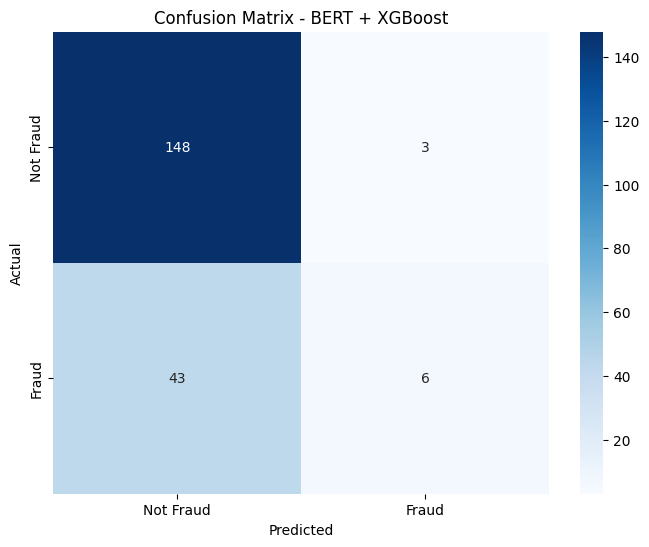

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Detailed evaluation metrics
print("=" * 60)
print("DETAILED EVALUATION RESULTS")
print("=" * 60)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nDetailed Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix - BERT + XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()